In [1]:
import os
import re
import pandas as pd
import numpy as np
import sklearn
import torch
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.util import ngrams
from collections import Counter

In [2]:
def parse_convote_data(base_path):
    file_names = os.listdir(base_path)
    data = []
    for fn in file_names:
        # Get metadata; https://www.cs.cornell.edu/home/llee/data/convote/README.v1.1.txt
        m = re.match(r"(?P<bill>\d\d\d)_(?P<speaker>\d\d\d\d\d\d)_"
                     + r"(?P<page_num>\d\d\d\d)(?P<speech_num>\d\d\d)_"
                     + r"(?P<party>\w)(?P<mentioned>\w)(?P<vote>\w)\.txt", fn)
        bill = int(m.group("bill"))
        speaker = int(m.group("speaker"))
        bill_directly_mentioned = m.group("mentioned")
        vote = m.group("vote")
        # Get text
        with open(base_path + fn) as f:
            text = f.read()
        punctuation = 0
        if ("?" in text): 
            punctuation = 1
        if ("!" in text): 
            punctuation = 2
        token = nltk.word_tokenize(text)
        unigrams = Counter(ngrams(token,1)).most_common(10)
        bigrams = Counter(ngrams(token,2)).most_common(10)


        # Save to dict
        data.append([bill, speaker, bill_directly_mentioned, text, vote, punctuation, unigrams, bigrams])  # base features

    df = pd.DataFrame(np.array(data), columns=["Bill number", "Speaker", "Bill mentioned",
                                               "Text", "Vote", "Punctuation", "Unigrams", "Bigrams"])
    sc = StandardScaler()
    df[["Punctuation"]] = sc.fit_transform(df[["Punctuation"]])
    return df

In [3]:
CONVOTE_DATA_DIR = "../convote_v1.1/data_stage_one/"
MODE = "training"  # or "test" or "development"

In [4]:
base_path = CONVOTE_DATA_DIR + MODE + "_set/"
df = parse_convote_data(base_path)

<ipython-input-2-8ac100d136f8>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(data), columns=["Bill number", "Speaker", "Bill mentioned",


In [5]:
df.head()

,Bill number,Speaker,Bill mentioned,Text,Vote,Punctuation,Unigrams,Bigrams
0,282,400436,M,"mr. speaker , i would like to say a word about...",N,-0.509268,"[((,,), 20), ((the,), 19), ((.,), 19), ((to,),...","[((the, world), 4), ((for, women), 3), ((women..."
1,88,400272,O,"mr. speaker , today we have some very clear ch...",N,-0.509268,"[((.,), 16), ((to,), 15), ((the,), 14), ((,,),...","[((this, bill), 6), ((we, can), 5), ((mr., spe..."
2,38,400080,O,"mr. speaker , i yield myself such time as i ma...",N,-0.509268,"[((the,), 23), ((.,), 15), ((,,), 13), ((to,),...","[((., the), 7), ((,, i), 4), ((civil, rights),..."
3,132,400227,O,"mr. chairman , i yield back the balance of my ...",N,-0.509268,"[((mr.,), 1), ((chairman,), 1), ((,,), 1), ((i...","[((mr., chairman), 1), ((chairman, ,), 1), ((,..."
4,282,400380,O,"madam chairman , will the gentleman yield ? \n",Y,1.851465,"[((madam,), 1), ((chairman,), 1), ((,,), 1), (...","[((madam, chairman), 1), ((chairman, ,), 1), (..."


In [6]:
print(len(df))

5660


In [7]:
# Per-debate stats
unique_bills = np.unique(df["Bill number"])
print("Number of debates:", len(unique_bills))
for ub in unique_bills[:3]:
    print("Bill #:", ub)
    speeches = df[df["Bill number"] == ub]
    print("# of speeches:", len(speeches))
    unique_speakers = np.unique(speeches["Speaker"])
    print("# of speakers:", len(unique_speakers))

Number of debates: 38
Bill #: 6
# of speeches: 70
# of speakers: 28
Bill #: 13
# of speeches: 72
# of speakers: 10
Bill #: 16
# of speeches: 53
# of speakers: 21


In [8]:
MODE = "development"  # can change to test
new_base_path = CONVOTE_DATA_DIR + MODE + "_set/"
testing_df = parse_convote_data(new_base_path)
testing_df.head()

<ipython-input-2-8ac100d136f8>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(data), columns=["Bill number", "Speaker", "Bill mentioned",


,Bill number,Speaker,Bill mentioned,Text,Vote,Punctuation,Unigrams,Bigrams
0,493,400036,O,"mr. chairman , i yield myself such time as i m...",Y,-0.494715,"[((,,), 13), ((the,), 11), ((.,), 7), ((in,), ...","[((the, 1964), 4), ((1964, civil), 4), ((civil..."
1,493,400321,M,"mr. chairman , i rise in strong support of the...",Y,-0.494715,"[((,,), 18), ((the,), 18), ((and,), 18), ((of,...","[((head, start), 11), ((early, head), 5), ((of..."
2,199,400322,O,"mr. chairman , i make a point of order against...",Y,-0.494715,"[((the,), 11), ((.,), 8), ((of,), 6), ((to,), ...","[((the, amendment), 3), ((point, of), 2), ((of..."
3,493,400103,O,"mr. chairman , i yield myself such time as i m...",N,-0.494715,"[((,,), 23), ((.,), 21), ((to,), 18), ((the,),...","[((head, start), 13), ((mr., chairman), 4), ((..."
4,199,400300,O,"mr. speaker , i yield back the balance of my t...",N,-0.494715,"[((mr.,), 1), ((speaker,), 1), ((,,), 1), ((i,...","[((mr., speaker), 1), ((speaker, ,), 1), ((,, ..."


In [9]:
from Model import *
from Baseline import *
from SimpleNN import *
from SimpleSVM import *
from bert import *

# TODO: add more...

In [10]:
# Train model
model = Baseline()
model.train(df)
predicted = model.predict_votes(testing_df.drop("Vote", axis=1))

In [11]:
df.head()

,Bill number,Speaker,Bill mentioned,Text,Vote,Punctuation,Unigrams,Bigrams
0,282,400436,M,"mr. speaker , i would like to say a word about...",N,-0.509268,"[((,,), 20), ((the,), 19), ((.,), 19), ((to,),...","[((the, world), 4), ((for, women), 3), ((women..."
1,88,400272,O,"mr. speaker , today we have some very clear ch...",N,-0.509268,"[((.,), 16), ((to,), 15), ((the,), 14), ((,,),...","[((this, bill), 6), ((we, can), 5), ((mr., spe..."
2,38,400080,O,"mr. speaker , i yield myself such time as i ma...",N,-0.509268,"[((the,), 23), ((.,), 15), ((,,), 13), ((to,),...","[((., the), 7), ((,, i), 4), ((civil, rights),..."
3,132,400227,O,"mr. chairman , i yield back the balance of my ...",N,-0.509268,"[((mr.,), 1), ((chairman,), 1), ((,,), 1), ((i...","[((mr., chairman), 1), ((chairman, ,), 1), ((,..."
4,282,400380,O,"madam chairman , will the gentleman yield ? \n",Y,1.851465,"[((madam,), 1), ((chairman,), 1), ((,,), 1), (...","[((madam, chairman), 1), ((chairman, ,), 1), (..."


In [12]:
# Evaluate model
num_corr = 0
num_tot = 0
assert(len(predicted) == len(testing_df["Vote"]))
for i in range(len(predicted)):
    num_tot += 1
    if predicted[i] == testing_df["Vote"][i]: num_corr += 1
print("Accuracy of SimpleNN:", num_corr / num_tot)

Accuracy of SimpleNN: 0.7008547008547008


In [13]:
df

,Bill number,Speaker,Bill mentioned,Text,Vote,Punctuation,Unigrams,Bigrams
0,282,400436,M,"mr. speaker , i would like to say a word about...",N,-0.509268,"[((,,), 20), ((the,), 19), ((.,), 19), ((to,),...","[((the, world), 4), ((for, women), 3), ((women..."
1,88,400272,O,"mr. speaker , today we have some very clear ch...",N,-0.509268,"[((.,), 16), ((to,), 15), ((the,), 14), ((,,),...","[((this, bill), 6), ((we, can), 5), ((mr., spe..."
2,38,400080,O,"mr. speaker , i yield myself such time as i ma...",N,-0.509268,"[((the,), 23), ((.,), 15), ((,,), 13), ((to,),...","[((., the), 7), ((,, i), 4), ((civil, rights),..."
3,132,400227,O,"mr. chairman , i yield back the balance of my ...",N,-0.509268,"[((mr.,), 1), ((chairman,), 1), ((,,), 1), ((i...","[((mr., chairman), 1), ((chairman, ,), 1), ((,..."
4,282,400380,O,"madam chairman , will the gentleman yield ? \n",Y,1.851465,"[((madam,), 1), ((chairman,), 1), ((,,), 1), (...","[((madam, chairman), 1), ((chairman, ,), 1), (..."
...,...,...,...,...,...,...,...,...
5655,321,400028,M,"mr. chairman , due to a previous and unavoidab...",Y,-0.509268,"[((,,), 8), ((and,), 5), ((``,), 4), ((to,), 3...","[((,, i), 2), ((``, on), 2), ((on, rollcall), ..."
5656,144,400365,O,"mr. speaker , will the gentleman yield ? \n",Y,1.851465,"[((mr.,), 1), ((speaker,), 1), ((,,), 1), ((wi...","[((mr., speaker), 1), ((speaker, ,), 1), ((,, ..."
5657,635,400036,O,i assume so . \n,Y,-0.509268,"[((i,), 1), ((assume,), 1), ((so,), 1), ((.,),...","[((i, assume), 1), ((assume, so), 1), ((so, .)..."
5658,88,400109,O,"yes , i am in opposition . \n",N,-0.509268,"[((yes,), 1), ((,,), 1), ((i,), 1), ((am,), 1)...","[((yes, ,), 1), ((,, i), 1), ((i, am), 1), ((a..."


# Document similarity

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from scipy.spatial import distance
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [15]:
def get_bill_similarities(df):
    def get_bill_text(bill_num: int):
        docs = df[df["Bill number"] == bill_num]
        out = ""
        for doc in docs["Text"]: out += doc
        return out
    
    data = []
    for bill_num in np.unique(df["Bill number"]):
        data.append(get_bill_text(int(bill_num)))

    tfidf = TfidfVectorizer()
    matrix = tfidf.fit_transform(data)
    return matrix

In [16]:
def get_document_distance(bill1: int, bill2: int, matrix, df, dist_func=distance.cosine):
    """Lower score is a smaller distance, i.e. more similar documents"""
    unique_docs = list(np.unique(df["Bill number"]))
    ind1 = unique_docs.index(bill1)
    ind2 = unique_docs.index(bill2)
    vec1 = matrix[ind1].toarray()[0]
    vec2 = matrix[ind2].toarray()[0]
    assert(vec1.shape == vec2.shape)
    
    return dist_func(vec1, vec2)

In [17]:
matrix = get_bill_similarities(df)
print(matrix.shape)
print("Num of unique bills:", len(np.unique(df["Bill number"])))

get_document_distance(88, 38, matrix, df)

(38, 23417)
Num of unique bills: 38


0.08494107365812098

In [18]:
unique_docs = list(np.unique(df["Bill number"]))
distance_data = {}
for i in range(len(unique_docs)):
    for j in range(i + 1, len(unique_docs)):
        tup = (int(unique_docs[i]), int(unique_docs[j]))
        distance_data[tup] = get_document_distance(tup[0], tup[1], matrix, df, dist_func=distance.euclidean)

Max tfidf: 1.0121102553681278
Min tfidf: 0.241751797157583


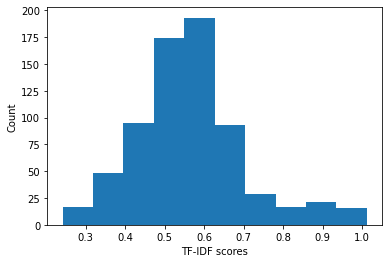

In [19]:
vals = []
for d in distance_data:
    vals.append(distance_data[d])
print("Max tfidf:", np.max(vals))
print("Min tfidf:", np.min(vals))
plt.hist(vals)
plt.ylabel("Count")
plt.xlabel("TF-IDF scores")
plt.show()

In [20]:
MIN_COMMON_SPEAKERS = 10

def get_voting_similarity(bill1: int, bill2: int, df):
    df1 = df[df["Bill number"] == bill1]
    df2 = df[df["Bill number"] == bill2]
    
    speaker1 = np.unique(df1["Speaker"])
    speaker2 = np.unique(df2["Speaker"])
    common = []
    for s in speaker1:
        if s in speaker2: common.append(s)
    #print("# Common speakers:", len(common))
    
    if len(common) < MIN_COMMON_SPEAKERS: return None
    
    tot = 0
    agree = 0
    for s in common:
        vote1 = df1[df1["Speaker"] == s]["Vote"].iloc[0]
        vote2 = df2[df2["Speaker"] == s]["Vote"].iloc[0]
        if vote1 == vote2: agree += 1
        tot += 1
    return agree / tot

vote_data = {}
for key in distance_data.keys():
    sim = get_voting_similarity(key[0], key[1], df)
    vote_data[key] = sim

Max similarity: 1.0
Min similarity: 0.21052631578947367


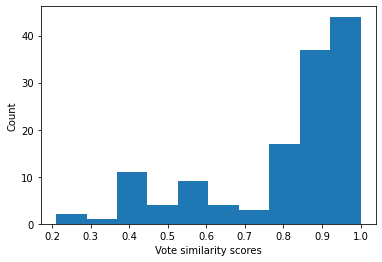

In [21]:
vals = []
for d in vote_data:
    if not vote_data[d]: continue
    vals.append(vote_data[d])
print("Max similarity:", np.max(vals))
print("Min similarity:", np.min(vals))
plt.hist(vals)
plt.ylabel("Count")
plt.xlabel("Vote similarity scores")
plt.show()

m: -0.533194672960132
b: 1.058047050889368


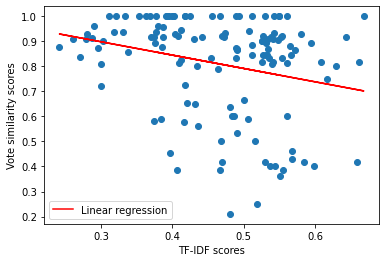

In [22]:
# Now compare distance_data and vote_data
vote_vals = []
dist_vals = []
for d in vote_data:
    if not vote_data[d]: continue
    vote_vals.append(vote_data[d])
    dist_vals.append(distance_data[d])
vote_vals = np.array(vote_vals).reshape(-1, 1)
dist_vals = np.array(dist_vals).reshape(-1, 1)
clf = LinearRegression().fit(dist_vals, vote_vals)
print("m:", clf.coef_[0][0])
print("b:", clf.intercept_[0])
plt.plot(dist_vals, clf.predict(dist_vals), c="r", label="Linear regression")

plt.scatter(dist_vals, vote_vals)
plt.ylabel("Vote similarity scores")
plt.xlabel("TF-IDF scores")
plt.legend()
plt.show()